In [1]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory
from anomaly.utils import specobjid_to_idx
from anomaly.utils import set_intersection
from astroExplain.spectra.utils import get_anomaly_score_name
from astroExplain.spectra.notebook import explanation_name
from astroExplain.spectra.notebook import interpret
from astroExplain.spectra.notebook import explain_reconstruction_score

meta = MetaData()
%matplotlib inline

In [3]:
# config
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}/{model_id}"
explanations_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"
scores_directory = f"{meta_data_directory}/bin_04/explanation/256_128_64/latent_12"

In [4]:
# load data
wave = np.load(f"{meta_data_directory}/wave.npy")
meta_data_df = pd.read_csv(f"{meta_data_directory}/0_01_z_0_5_4_0_snr_inf.csv.gz", index_col="specobjid")
model = AutoEncoder(reload=True, reload_from=model_directory)
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
idx_id = np.load(f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy")

In [5]:
# anomaly score
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": True,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}


In [6]:
# spectrum
specobjid = 2664004586678806528
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]
# plt.plot(wave, spectrum)

### Original explanation

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2664004586678806528&apid=


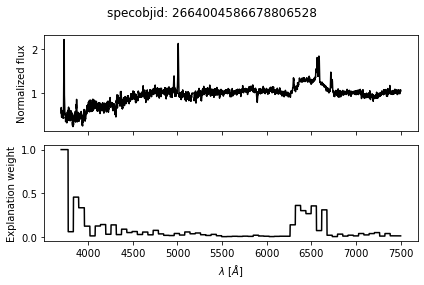

In [7]:
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": False,
    "kernel_size": 3,
    "sigma": 0
}

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

## Perturbation

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2664004586678806528&apid=


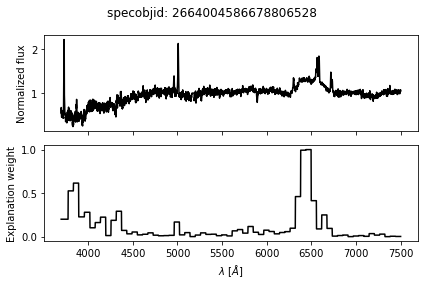

In [11]:
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "flat",
# scale
    "scale_factor": 1.1,
# flat
    "continuum": 1.,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1.
}

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/perturbation"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)
n_samples = lime_config["number_samples"]

fig.savefig(
    f"{save_to}/{explanation_str}_samples_{n_samples}.pdf"
)

## Samples

## Segmentation